In [ ]:
# !pip install openpyxl
# !pip install imbalanced-learn
# !pip3 install ipympl
# !pip install import-ipynb
# !pip install shapely
# !pip install SciencePlots 
# !pip install seaborn
# !pip install tqdm
# !pip install ipywidgets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import os, sys
from numpy import nan
import re
import ipympl
# from IPython.core.display import display, HTML
import ipywidgets
import json
from os import listdir
import glob
import math
from IPython.display import Image, display, HTML
from shapely.geometry import mapping
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, precision_score, recall_score, mean_absolute_error, make_scorer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, LeaveOneOut, cross_validate
from sklearn.impute import SimpleImputer
from tqdm.notebook import tqdm
from sklearn.svm import SVC
from tqdm import tqdm
import pickle
from imblearn.over_sampling import SMOTE
from scipy.stats import ks_2samp
from scipy import stats
np.seterr(divide='ignore', invalid='ignore')
pd.options.display.max_columns = 100
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

In [2]:
import import_ipynb
from SoilPrep import * 

importing Jupyter notebook from SoilPrep.ipynb


# Step 1: Data Preprocessing (Normalisation)

In [61]:
# Colour scheme definition
kado = '#8B7355'
mati = '#A52A2A'
balu = '#F4A460'

udf = pd.read_csv('uae.csv')
print(udf.shape)
print(udf["FID"].min(), udf["FID"].max())
# Note that some ids are missing in the data

(294, 2158)
1 325


In [62]:
udf['sand'] = lognormal (udf['sand'].copy())
udf['silt'] = lognormal (udf['silt'].copy())
udf['clay'] = lognormal (udf['clay'].copy())
udf['TOC'] = lognormal (udf['TOC'].copy())

# plt.hist(udf['clay'], bins=98)
# plt.show()


## Correlation between wavelengths and Targets

In [63]:
plt.style.use(['science','notebook','grid'])
# Pearson corelation between different wavelengths and Targets/Outputs (i.e, sand, clay, silt, and TOC) 

# First and second row of sand_rp will store r values and p values for different wavelengths
# Similar is the case for silt_rp, clay_rp, and toc_rp
sand_rp = udf.loc[0:1,:].copy()
silt_rp = udf.loc[0:1,:].copy()
clay_rp = udf.loc[0:1,:].copy()
toc_rp = udf.loc[0:1,:].copy()

# Calculating r value and p value for different wavelengths when calculated against different Targets 
for i in range(7,2158):
    sand_rp.iloc[0, i], sand_rp.iloc[1, i] = stats.pearsonr(udf.loc[:,'sand'], udf.iloc[:, i])
    silt_rp.iloc[0, i], silt_rp.iloc[1, i] = stats.pearsonr(udf.loc[:,'silt'], udf.iloc[:, i])
    clay_rp.iloc[0, i], clay_rp.iloc[1, i] = stats.pearsonr(udf.loc[:,'clay'], udf.iloc[:, i])
    toc_rp.iloc[0, i], toc_rp.iloc[1, i] = stats.pearsonr(udf.loc[:,'TOC'], udf.iloc[:, i])
    
# Ploting the pearson correlation coefficient for different wavelengths against different Targets

def plot_corr (target):
    if target == 'sand':
        sand_rp.iloc[0,7:].plot(color = balu)
    elif target == 'silt':
        silt_rp.iloc[0,7:].plot(color = kado) 
    elif target == 'TOC':
        toc_rp.iloc[0,7:].plot(color = 'green')
    elif target == 'clay':
        clay_rp.iloc[0,7:].plot(color = mati)   
    else:
        clay_rp.iloc[0,7:].plot(color = mati)
        sand_rp.iloc[0,7:].plot(color = balu)
        silt_rp.iloc[0,7:].plot(color = kado) 
        toc_rp.iloc[0,7:].plot(color = 'green') 
    plt.ylim([-0.6, 0.6])

ipywidgets.interact(plot_corr, target= ['sand', 'silt', 'clay', 'TOC', 'All'])



interactive(children=(Dropdown(description='target', options=('sand', 'silt', 'clay', 'TOC', 'All'), value='sa…

<function __main__.plot_corr(target)>

## Visualizing Spectrum by Increasing Target Contents (Interactive)

In [64]:
# Sorting spectra by Sand content
bySand = udf.sort_values(by =['sand'])
bySand = bySand.reset_index(drop=True)

# Sorting spectra by Silt content
bySilt = udf.sort_values(by =['silt'])
bySilt = bySilt.reset_index(drop=True)

# Sorting spectra by Clay content
byClay = udf.sort_values(by =['clay'])
byClay = byClay.reset_index(drop=True)

# Sorting spectra by Total Organic Content(TOC)
byTOC = udf.sort_values(by =['TOC'])
byTOC = byTOC.reset_index(drop=True)

# Using ipywidgets to draw interactive plots

def plot_spec (sort_by, cor, sample):
    if sort_by == 'sand':
        x= bySand.iloc[sample, 7:2158]
        if cor == 'on':
            sand_rp.iloc[0,7:].plot(color = balu)
    elif sort_by == 'silt':
        x= bySilt.iloc[sample, 7:2158]
        if cor == 'on':
            silt_rp.iloc[0,7:].plot(color = kado)
    elif sort_by == 'TOC':
        x= byTOC.iloc[sample, 7:2158]
        if cor == 'on':
            toc_rp.iloc[0,7:].plot(color = 'green')
    else:
        x= byClay.iloc[sample, 7:2158]
        if cor == 'on':
            clay_rp.iloc[0,7:].plot(color = mati)
    x.plot()
    plt.ylim([-0.6, 0.8])

ipywidgets.interact(plot_spec, sort_by= ['sand', 'clay', 'silt', 'TOC'], cor = ['on', 'off'], sample = (0, 293,1))

interactive(children=(Dropdown(description='sort_by', options=('sand', 'clay', 'silt', 'TOC'), value='sand'), …

<function __main__.plot_spec(sort_by, cor, sample)>

# Step 3:  Train-Test Split  and its Goodness

In [65]:
y_silt = udf.loc[:, 'silt']
y_sand = udf.loc[:, 'sand']
y_clay = udf.loc[:, 'clay']
y_toc = udf.loc[:, 'TOC']

In [66]:
tst_siz = 0.3
X = udf.iloc[:, 7:2158].copy()

rand_sand, min_err = best_split(X, y_sand, tst_siz)
print ('Sand: ')
print ('For test size =', tst_siz, '\t min bin error:', min_err, '\t found at randome state =', rand_sand)

rand_silt, min_err = best_split(X, y_silt, tst_siz)
print ('Silt: ')
print ('For test size =', tst_siz, '\t min bin error:', min_err, '\t found at randome state =', rand_silt)

rand_clay, min_err = best_split(X, y_clay, tst_siz)
print ('Clay: ')
print ('For test size =', tst_siz, '\t min bin error:', min_err, '\t found at randome state =', rand_clay)

rand_toc, min_err = best_split(X, y_toc, tst_siz)
print ('TOC: ')
print ('For test size =', tst_siz, '\t min bin error:', min_err, '\t found at randome state =', rand_toc)

Sand: 
For test size = 0.3 	 min bin error: 36.19047619047619 	 found at randome state = 3
Silt: 
For test size = 0.3 	 min bin error: 26.66666666666666 	 found at randome state = 4
Clay: 
For test size = 0.3 	 min bin error: 30.476190476190474 	 found at randome state = 8
TOC: 
For test size = 0.3 	 min bin error: 26.66666666666666 	 found at randome state = 17


##  Optimal Train-Test Split

In [67]:
# Splitting the sample into train-test samples using obtained optimal parameters
XSand_train, XSand_test, ySand_train, ySand_test = train_test_split(X, y_sand, test_size= tst_siz, random_state=rand_sand)

XSilt_train, XSilt_test, ySilt_train, ySilt_test = train_test_split(X, y_silt, test_size= tst_siz, random_state=rand_silt)

XClay_train, XClay_test, yClay_train, yClay_test = train_test_split(X, y_clay, test_size= tst_siz, random_state=rand_clay)

XTOC_train, XTOC_test, yTOC_train, yTOC_test = train_test_split(X, y_toc, test_size= tst_siz, random_state=rand_toc)
print ('\n \n Optimal Train-Test Split Done for y_sand y_silt y_clay y_toc')


 
 Optimal Train-Test Split Done for y_sand y_silt y_clay y_toc


Text(0.5, 0.95, 'Train Test Distribution of Data')

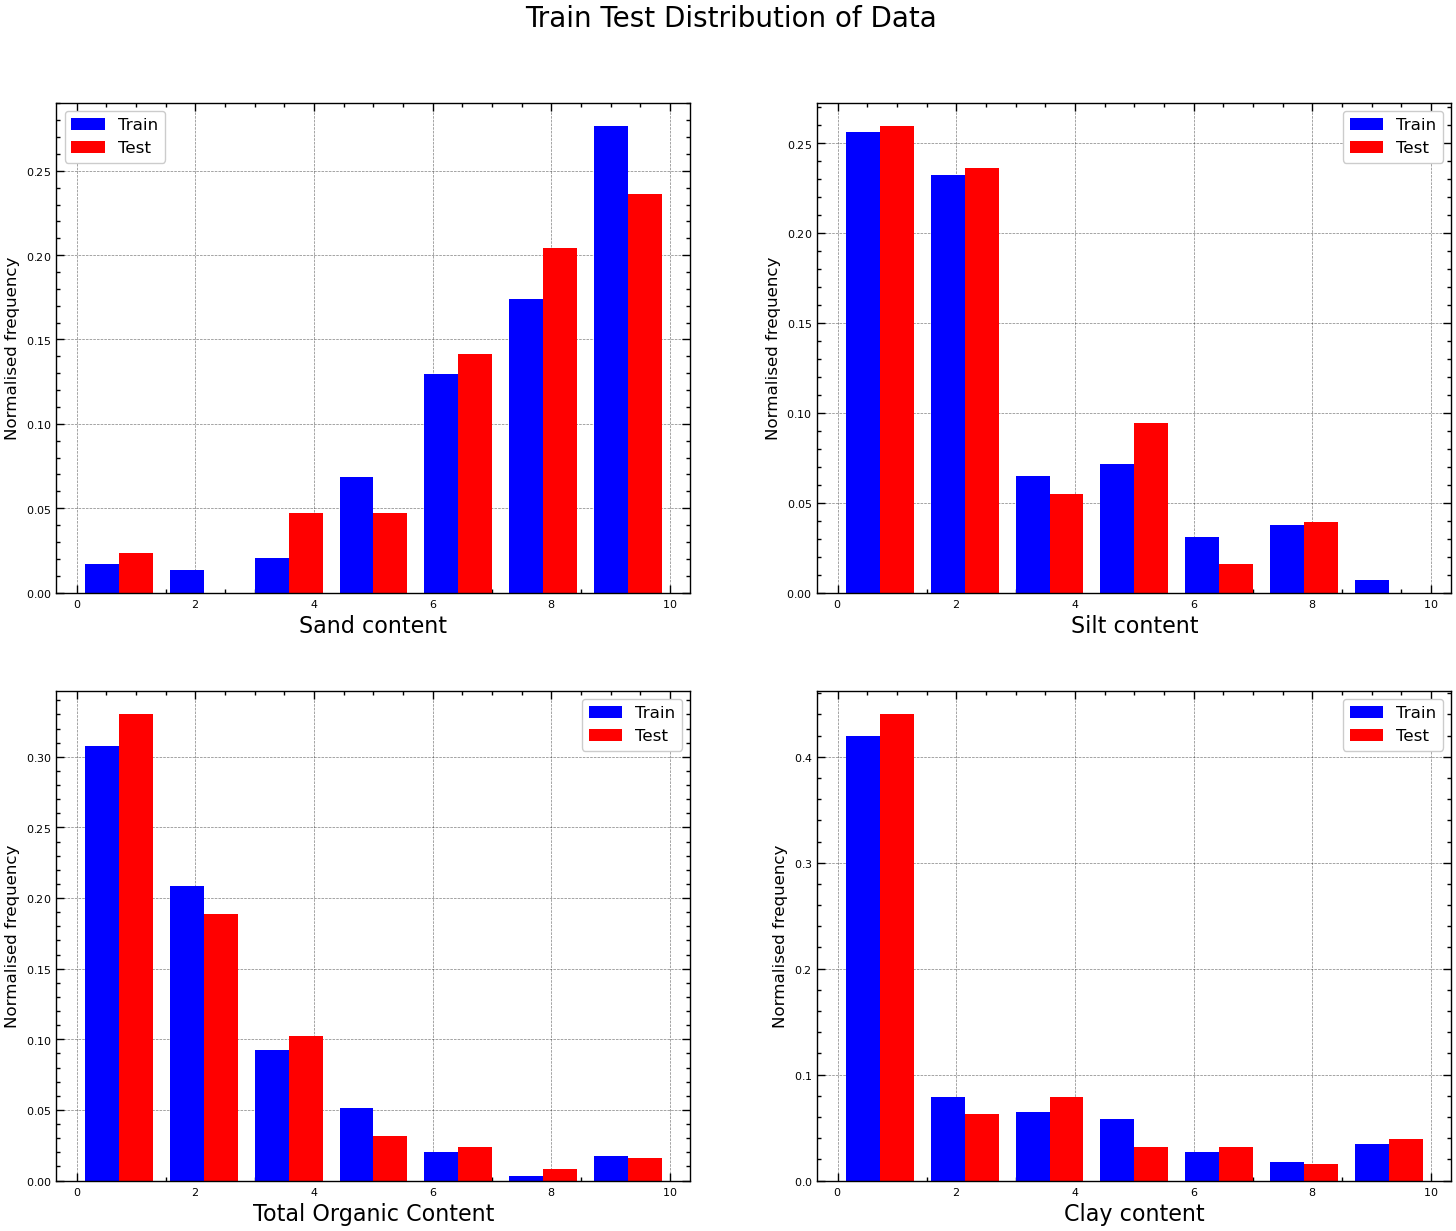

In [68]:
# ## Plotting the Distribution of Train and Test Output Data 
plt.style.use(['science','notebook','grid'])

fig, ax = plt.subplots(2,2, figsize=(18,14))

minSand = np.min(y_sand)
maxSand = np.max(y_sand)

binsSand = np.linspace(minSand, maxSand, 8)
# density =True : used to normalise bin heights to make the integral of  histogram 1.
ax[0][0].hist([ySand_train, ySand_test], binsSand , label=['Train', 'Test'], density=True, color = ['blue','red'])
# results in error when yN_train/ yN_test is data frame or ndarray
ax[0][0].legend(loc='upper left', fontsize =12)
ax[0][0].set_xlabel('Sand content',fontsize =16)
ax[0][0].set_ylabel('Normalised frequency',fontsize =12)
ax[0][0].tick_params(axis='both', labelsize=8)

minSilt = np.min(y_silt)
maxSilt = np.max(y_silt)

binsSilt = np.linspace(minSilt, maxSilt, 8)
# density =True : used to normalise bin heights to make the integral of  histogram 1.
ax[0][1].hist([ySilt_train, ySilt_test], binsSilt , label=['Train', 'Test'], density=True, color = ['blue','red'])
# results in error when yN_train/ yN_test is data frame or ndarray
ax[0][1].legend(loc='upper right', fontsize =12)
ax[0][1].set_xlabel('Silt content',fontsize =16)
ax[0][1].set_ylabel('Normalised frequency',fontsize =12)
ax[0][1].tick_params(axis='both', labelsize=8)

minClay = np.min(y_clay)
maxClay = np.max(y_clay)

binsClay = np.linspace(minClay, maxClay, 8)
# density =True : used to normalise bin heights to make the integral of  histogram 1.
ax[1][1].hist([yClay_train, yClay_test], binsClay , label=['Train', 'Test'], density=True, color = ['blue','red'])
# results in error when yN_train/ yN_test is data frame or ndarray
ax[1][1].legend(loc='upper right', fontsize =12)
ax[1][1].set_xlabel('Clay content',fontsize =16)
ax[1][1].set_ylabel('Normalised frequency',fontsize =12)
ax[1][1].tick_params(axis='both', labelsize=8)

minTOC = np.min(y_toc)
maxTOC = np.max(y_toc)

binsTOC = np.linspace(minTOC, maxTOC, 8)
# density =True : used to normalise bin heights to make the integral of  histogram 1.
ax[1][0].hist([yTOC_train, yTOC_test], binsTOC , label=['Train', 'Test'], density=True, color = ['blue','red'])
# results in error when yN_train/ yN_test is data frame or ndarray
ax[1][0].legend(loc='upper right', fontsize =12)
ax[1][0].set_xlabel('Total Organic Content',fontsize =16)
ax[1][0].set_ylabel('Normalised frequency',fontsize =12)
ax[1][0].tick_params(axis='both', labelsize=8)

fig.suptitle('Train Test Distribution of Data', x = 0.5 ,y = .95, fontsize = 20)

#plt.show()

# Finding best Model (window, n_components)

In [69]:
# z= y_silt.sort_values().reset_index(drop=True)
# #z= z.reset_index(drop=True)
# len(z)
# z[280]


In [97]:
from sklearn import linear_model

def best_param_PLSR (spectra, target, rand_st, tst_siz, window, n_comp):
    X= spectra.copy()
    y= target.copy()
     
    iqrpM = np.zeros(shape=(window, n_comp))
    # test train split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = tst_siz, random_state=rand_st)
    for w in range (0,window):
        X_train_smth = sgsmooth (X_train, w)
        X_test_smth = sgsmooth (X_test, w)
        for n in range(1,n_comp):
            Model = PLSRegression(n_components=n, scale=True)
            
            Model.fit(X_train_smth, y_train)
            y_pred = Model.predict(X_test, copy=True)
            yhat_pred = Model.predict(X_train, copy=True)            
#             #  Calculate the rmse for training data
#             mseTrain = mean_squared_error(y_train, yhat_pred)
#             rmseTrain = np.sqrt(mseTrain)
#             #  Calculate the rmse and rpd for testing data
#             mseTest = mean_squared_error(y_test, y_pred)
#             rmseTest = np.sqrt(mseTest)
            
            iqrp_test = iqrp(y_pred, y_test)
            iqrp_train = iqrp(yhat_pred, y_train)
            
            iqrpM[w,n] = iqrp_test
            
            if iqrp_test == iqrpM.max():
                bestw = w
                bestn = n
                maxIQRP = iqrp_test
                print('Found new best at w=', w, 'n=', n,  '>>   IQRP_test =', iqrp_test, '>>   IQRP_train =', iqrp_train)
                #print('Current iqrp_train =', iqrp_train)
    return (bestw, bestn, maxIQRP)


spectra = udf.iloc[:, 7:2158].copy()

#w, n, IQRP = best_param_PLSR (spectra, y_sand, rand_sand, 0.2, 5,20)
            
#w, n, IQRP = best_param_PLSR (spectra, y_silt, rand_silt, 0.2, 5,20)  

w, n, IQRP = best_param_PLSR (spectra, y_clay, rand_clay, 0.2, 5,20)

#w, n, IQRP = best_param_PLSR (spectra, y_toc, rand_toc, 0.2, 5,20)
            
            
    




Found new best at w= 0 n= 1 >>   IQRP_test = 1.510227655761468 >>   IQRP_train = 1.6021698803975797
Found new best at w= 0 n= 2 >>   IQRP_test = 1.536001390125735 >>   IQRP_train = 1.6337911532555298
Found new best at w= 0 n= 3 >>   IQRP_test = 1.6969072157145753 >>   IQRP_train = 1.8602074951768024
Found new best at w= 0 n= 4 >>   IQRP_test = 1.7945891650843118 >>   IQRP_train = 1.9221377010779979
Found new best at w= 0 n= 5 >>   IQRP_test = 1.981906153512134 >>   IQRP_train = 1.9977863029890932
Found new best at w= 0 n= 7 >>   IQRP_test = 1.9853122859408172 >>   IQRP_train = 2.081576153262159
Found new best at w= 0 n= 8 >>   IQRP_test = 2.0126181011340494 >>   IQRP_train = 2.1141616968964407
Found new best at w= 0 n= 9 >>   IQRP_test = 2.0381014899009857 >>   IQRP_train = 2.1469152716070865
Found new best at w= 0 n= 11 >>   IQRP_test = 2.040747191726114 >>   IQRP_train = 2.2318127367849776


# Step 4: Training the Model

        - Create a linear regr object
        - Apply fit function (using regr object) on training data
        - Check the weights/parameters generated by fit function 

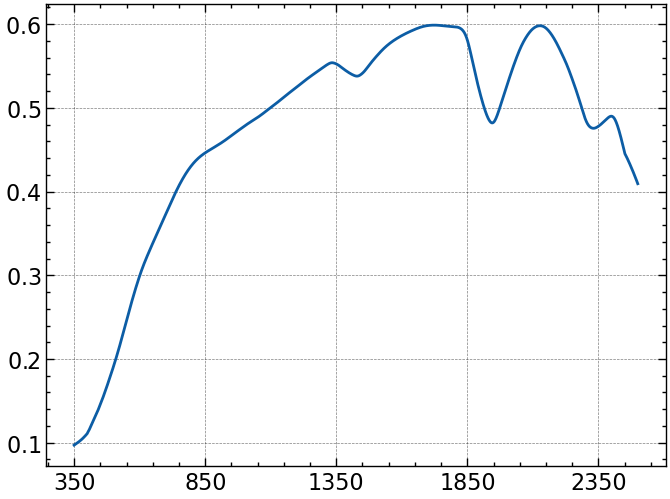

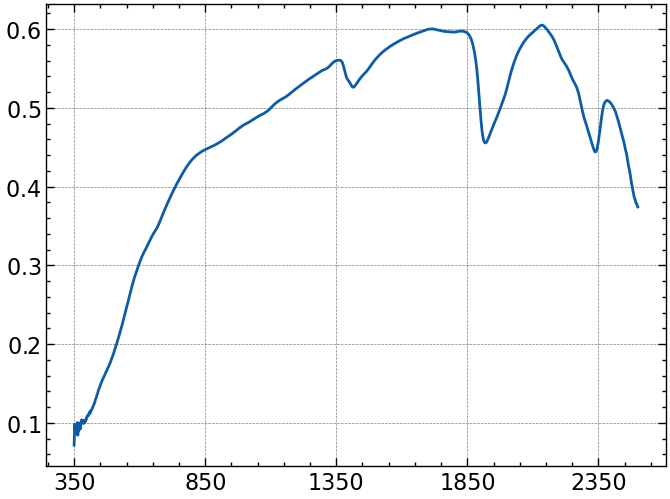

In [105]:
spectra = udf.iloc[:,7:2158].copy()
smth_spec = sgsmooth (spectra,50)

smth_spec.iloc[1,:].plot()
plt.show()
spectra.iloc[1,:].plot()
plt.show()

In [106]:
from sklearn import linear_model

regSand = PLSRegression(n_components=10, scale=True)
regSilt = PLSRegression(n_components=10, scale=True)
regClay = PLSRegression(n_components=10, scale=True)
regTOC = PLSRegression(n_components=10, scale=True)


# train the model using X_train and y_train (identified in previous step)

regSand.fit(XSand_train, ySand_train)
regSilt.fit(XSilt_train, ySilt_train)
regClay.fit(XClay_train, yClay_train)
regTOC.fit(XTOC_train, yTOC_train)



PLSRegression(n_components=10)

# Step 5: Prediction on Test Data 

In [107]:
# Predition using the trained-Model on the "Test Data"

ySand_pred = regSand.predict(XSand_test,copy=True)
ySand_pred = np.round(ySand_pred, 2)

ySilt_pred = regSilt.predict(XSilt_test,copy=True)
ySilt_pred = np.round(ySilt_pred, 2)

yClay_pred = regClay.predict(XClay_test,copy=True)
yClay_pred = np.round(yClay_pred, 2)

yTOC_pred = regTOC.predict(XTOC_test,copy=True)
yTOC_pred = np.round(yTOC_pred, 2)


# Step 6: Model Accuracy and Plots

###  Model Accuracy  (Sand)

In [109]:
#  Mean percentage error
#error = np.mean(abs((ySand_pred - ySand_test)/ySand_test))

#  Calculate the rmse for training data
yhatSand_pred = regSand.predict(XSand_train)
mseTrain = mean_squared_error(ySand_train, yhatSand_pred)
rmseTrain = np.sqrt(mseTrain)
#  Calculate the rmse for testing data
mseTest = mean_squared_error(ySand_test, ySand_pred)
rmseTest = np.sqrt(mseTest)

print('Sand Model Accuracy') 
#print('Mean Percentage Error:', error*100)  
print('Root Mean Square Error (Training): %.3f' % rmseTrain)
print('Root Mean Square Error (Testing): %.3f' % rmseTest)
print('Ratio of Performance to Deviation (RPD):', iqrp(ySand_pred, ySand_test))
rmseSand = rmseTest
rmseSandTr = rmseTrain
#ySand_test.std()

Sand Model Accuracy
Root Mean Square Error (Training): 1.516
Root Mean Square Error (Testing): 1.606
Ratio of Performance to Deviation (RPD): 1.6604808247050837


###  Model Accuracy  (Silt)

In [110]:
#  Mean percentage error

#  Calculate the rmse for training data
yhatSilt_pred = regSilt.predict(XSilt_train)
mseTrain = mean_squared_error(ySilt_train, yhatSilt_pred)
rmseTrain = np.sqrt(mseTrain)
#  Calculate the rmse for testing data
mseTest = mean_squared_error(ySilt_test, ySilt_pred)
rmseTest = np.sqrt(mseTest)

print('Silt Model Accuracy')   
print('Root Mean Square Error (Training): %.3f' % rmseTrain)
print('Root Mean Square Error (Testing): %.3f' % rmseTest)
print('Ratio of Performance to Deviation (RPD):', ySilt_test.std()/rmseTest)
#print('Mean Percentage Error:', rmseTest*100/(ySilt_test.mean()))
rmseSilt = rmseTest
rmseSiltTr = rmseTrain

Silt Model Accuracy
Root Mean Square Error (Training): 1.645
Root Mean Square Error (Testing): 1.709
Ratio of Performance to Deviation (RPD): 1.2548475701678663


###  Model Accuracy  (Clay)

In [ ]:
#  Mean percentage error

#  Calculate the rmse for training data
yhatClay_pred = regClay.predict(XClay_train)
mseTrain = mean_squared_error(yClay_train, yhatClay_pred)
rmseTrain = np.sqrt(mseTrain)
#  Calculate the rmse for testing data
mseTest = mean_squared_error(yClay_test, yClay_pred)
rmseTest = np.sqrt(mseTest)

print('Clay Model Accuracy') 
print('Root Mean Square Error (Training): %.3f' % rmseTrain)
print('Root Mean Square Error (Testing): %.3f' % rmseTest)
print('Ratio of Performance to Deviation (RPD):', yClay_test.std()/rmseTest)
#print('Mean Percentage Error:', rmseTest*100/(yClay_test.mean()))
rmseClay = rmseTest
rmseClayTr = rmseTrain

###  Model Accuracy  (TOC)

In [ ]:
#  Mean percentage error

#  Calculate the rmse for training data
yhatTOC_pred = regTOC.predict(XTOC_train)
mseTrain = mean_squared_error(yTOC_train, yhatTOC_pred)
rmseTrain = np.sqrt(mseTrain)
#  Calculate the rmse for testing data
mseTest = mean_squared_error(yTOC_test, yTOC_pred)
rmseTest = np.sqrt(mseTest)

print('Total Organic Content Model Accuracy') 
#print('Mean Percentage Error:', error*100)  
print('Root Mean Square Error (Training): %.3f' % rmseTrain)
print('Root Mean Square Error (Testing): %.3f' % rmseTest)
print('Ratio of Performance to Deviation (RPD):', yTOC_test.std()/rmseTest)
#print('Mean Percentage Error:', rmseTest*100/(yTOC_test.mean()))
rmseTOC = rmseTest
rmseTOCTr = rmseTrain

In [ ]:
ySand_test.values.shape

In [ ]:
ySand_pred.shape

In [ ]:
# Merging actual and predicted (Test data) in one data frame for plots
ySand_tp = pd.DataFrame({'actual':ySand_test.values, 'predic': ySand_pred[:,0]})
ySand_sortedA = ySand_tp.sort_values(by =['actual'])
ySand_srtA = ySand_sortedA.reset_index(drop=True)

ySilt_tp = pd.DataFrame({'actual':ySilt_test.values, 'predic': ySilt_pred[:,0]})
ySilt_sortedA = ySilt_tp.sort_values(by =['actual'])
ySilt_srtA = ySilt_sortedA.reset_index(drop=True)

yClay_tp = pd.DataFrame({'actual':yClay_test.values, 'predic': yClay_pred[:,0]})
yClay_sortedA = yClay_tp.sort_values(by =['actual'])
yClay_srtA = yClay_sortedA.reset_index(drop=True)

yTOC_tp = pd.DataFrame({'actual':yTOC_test.values, 'predic': yTOC_pred[:,0]})
yTOC_sortedA = yTOC_tp.sort_values(by =['actual'])
yTOC_srtA = yTOC_sortedA.reset_index(drop=True)

In [ ]:
# Plots for Visualising the Model Accuracy
plt.style.use(['science','notebook','grid'])

def plot_pred_acc (target):

    fig, axes = plt.subplots(1,1, figsize=(8,7))

    if target == 'sand':
        ySand_srtA.plot.scatter(ax= axes, x="actual", y="predic", alpha=0.8, color = balu)
        axes.tick_params(axis='both', labelsize=10)
        plt.text(1, 11, 'SAND', fontsize = 20, color = balu)
        plt.text(1, 10.2, 'RMSE ={:.2f}'.format(rmseSand), fontsize = 16)

    elif target == 'clay':
        yClay_srtA.plot.scatter(ax= axes, x="actual", y="predic", alpha=0.8, color = mati)
        axes.tick_params(axis='both', labelsize=10)
        plt.text(1, 11, 'CLAY', fontsize = 20, color = mati)
        plt.text(1, 10.2, 'RMSE ={:.2f}'.format(rmseClay), fontsize = 16)
        
    elif target == 'silt':
        ySilt_srtA.plot.scatter(ax= axes, x="actual", y="predic", alpha=0.8, color = kado)
        axes.tick_params(axis='both', labelsize=10)
        plt.text(1, 11, 'SILT', fontsize = 20, color = kado)
        plt.text(1, 10.2, 'RMSE ={:.2f}'.format(rmseSilt), fontsize = 16)

    elif target == 'TOC':
        yTOC_srtA.plot.scatter(ax= axes, x="actual", y="predic", alpha=0.8, color = 'green')
        axes.tick_params(axis='both', labelsize=10)
        plt.text(1, 11, 'TOC', fontsize = 20, color = 'green')
        plt.text(1, 10.2, 'RMSE ={:.2f}'.format(rmseTOC), fontsize = 16)
        
    else:  
        ySand_srtA.plot.scatter(ax= axes, x="actual", y="predic", alpha=0.8, color = balu)
        axes.tick_params(axis='both', labelsize=10)
        plt.text(3, 11, 'SAND', fontsize = 20, color = balu)
        yClay_srtA.plot.scatter(ax= axes, x="actual", y="predic", alpha=0.8, color = mati)
        axes.tick_params(axis='both', labelsize=10)
        plt.text(3, 10, 'CLAY', fontsize = 20, color = mati)
        ySilt_srtA.plot.scatter(ax= axes, x="actual", y="predic", alpha=0.8, color = kado)
        axes.tick_params(axis='both', labelsize=10)
        plt.text(1, 11, 'SILT', fontsize = 20, color = kado)
        yTOC_srtA.plot.scatter(ax= axes, x="actual", y="predic", alpha=0.8, color = 'green')
        axes.tick_params(axis='both', labelsize=10)
        plt.text(1, 10, 'TOC', fontsize = 20, color = 'green')

    fig.suptitle('Predictions on "Test" Data', x = 0.5 ,y = .95, fontsize=20)
    plt.xlim([0, 12])
    plt.ylim([0, 12])
    plt.show()

ipywidgets.interact(plot_pred_acc, target = ['sand', 'clay', 'silt', 'TOC', 'All'])


# Step 7: Outliers Detection 

## Prediction on Train Data

In [ ]:
# Predition using the trained-Model on the "Train Data"

ySand_predT = regSand.predict(XSand_train,copy=True)
ySand_predT = np.round(ySand_predT, 2)

ySilt_predT = regSilt.predict(XSilt_train,copy=True)
ySilt_predT = np.round(ySilt_predT, 2)

yClay_predT = regClay.predict(XClay_train,copy=True)
yClay_predT = np.round(yClay_predT, 2)

yTOC_predT = regTOC.predict(XTOC_train,copy=True)
yTOC_predT = np.round(yTOC_predT, 2)

In [ ]:
# Merging actual and predicted (Train data) in one data frame for plots
ySand_trp = pd.DataFrame({'actual':ySand_train.values, 'predic': ySand_predT[:,0]})
ySand_sortedAT = ySand_trp.sort_values(by =['actual'])
ySand_srtAT = ySand_sortedAT.reset_index(drop=True)

ySilt_trp = pd.DataFrame({'actual':ySilt_train.values, 'predic': ySilt_predT[:,0]})
ySilt_sortedAT = ySilt_trp.sort_values(by =['actual'])
ySilt_srtAT = ySilt_sortedAT.reset_index(drop=True)

yClay_trp = pd.DataFrame({'actual':yClay_train.values, 'predic': yClay_predT[:,0]})
yClay_sortedAT = yClay_trp.sort_values(by =['actual'])
yClay_srtAT = yClay_sortedAT.reset_index(drop=True)

yTOC_trp = pd.DataFrame({'actual':yTOC_train.values, 'predic': yTOC_predT[:,0]})
yTOC_sortedAT = yTOC_trp.sort_values(by =['actual'])
yTOC_srtAT = yTOC_sortedAT.reset_index(drop=True)

# Model comparision on Test and Train Data

In [ ]:
# Plots for Visualising the Model Accuracy
plt.style.use(['science','notebook','grid'])

def plot_pred_accTr (target):

    fig, axes = plt.subplots(1,2, figsize=(18,7))

    if target == 'sand':
        ySand_srtA.plot.scatter(ax= axes[0], x="actual", y="predic", alpha=0.8, color = balu)
        axes[0].tick_params(axis='both', labelsize=10)
        axes[0].text(1, 11, 'SAND', fontsize = 20, color = balu)
        axes[0].text(5, 11, 'TEST', fontsize = 30, color = 'red')
        axes[0].text(1, 10.2, 'RMSE ={:.2f}'.format(rmseSand), fontsize = 16)  
        
        ySand_srtAT.plot.scatter(ax= axes[1], x="actual", y="predic", alpha=0.8, color = balu)
        axes[1].tick_params(axis='both', labelsize=10)
        axes[1].text(1, 11, 'SAND', fontsize = 20, color = balu)
        axes[1].text(5, 11, 'TRAIN', fontsize = 30, color = 'blue')
        axes[1].text(1, 10.2, 'RMSE ={:.2f}'.format(rmseSandTr), fontsize = 16)

    elif target == 'clay':
        yClay_srtA.plot.scatter(ax= axes[0], x="actual", y="predic", alpha=0.8, color = mati)
        axes[0].tick_params(axis='both', labelsize=10)
        axes[0].text(1, 11, 'CLAY', fontsize = 20, color = mati)
        axes[0].text(5, 11, 'TEST', fontsize = 30, color = 'red')
        axes[0].text(1, 10.2, 'RMSE ={:.2f}'.format(rmseClay), fontsize = 16) 
        
        yClay_srtAT.plot.scatter(ax= axes[1], x="actual", y="predic", alpha=0.8, color = mati)
        axes[1].tick_params(axis='both', labelsize=10)
        axes[1].text(1, 11, 'CLAY', fontsize = 20, color = mati)
        axes[1].text(5, 11, 'TRAIN', fontsize = 30, color = 'blue')
        axes[1].text(1, 10.2, 'RMSE ={:.2f}'.format(rmseClayTr), fontsize = 16)
        
    elif target == 'silt':
        ySilt_srtA.plot.scatter(ax= axes[0], x="actual", y="predic", alpha=0.8, color = kado)
        axes[0].tick_params(axis='both', labelsize=10)
        axes[0].text(1, 11, 'SILT', fontsize = 20, color = kado)
        axes[0].text(5, 11, 'TEST', fontsize = 30, color = 'red')
        axes[0].text(1, 10.2, 'RMSE ={:.2f}'.format(rmseSilt), fontsize = 16) 
        
        ySilt_srtAT.plot.scatter(ax= axes[1], x="actual", y="predic", alpha=0.8, color = kado)
        axes[1].tick_params(axis='both', labelsize=10)
        axes[1].text(1, 11, 'SILT', fontsize = 20, color = kado)
        axes[1].text(5, 11, 'TRAIN', fontsize = 30, color = 'blue')
        axes[1].text(1, 10.2, 'RMSE ={:.2f}'.format(rmseSiltTr), fontsize = 16)

    elif target == 'TOC':
        yTOC_srtA.plot.scatter(ax= axes[0], x="actual", y="predic", alpha=0.8, color = 'green')
        axes[0].tick_params(axis='both', labelsize=10)
        axes[0].text(1, 11, 'TOC', fontsize = 20, color = 'green')
        axes[0].text(5, 11, 'TEST', fontsize = 30, color = 'red')
        axes[0].text(1, 10.2, 'RMSE ={:.2f}'.format(rmseTOC), fontsize = 16)
        
        yTOC_srtAT.plot.scatter(ax= axes[1], x="actual", y="predic", alpha=0.8, color = 'green')
        axes[1].tick_params(axis='both', labelsize=10)
        axes[1].text(1, 11, 'TOC', fontsize = 20, color = 'green')
        axes[1].text(5, 11, 'TRAIN', fontsize = 30, color = 'blue')
        axes[1].text(1, 10.2, 'RMSE ={:.2f}'.format(rmseTOCTr), fontsize = 16)
        
    else:  
        ySand_srtA.plot.scatter(ax= axes[0], x="actual", y="predic", alpha=0.8, color = balu)
        axes[0].tick_params(axis='both', labelsize=10)
        axes[0].text(3, 11, 'SAND', fontsize = 20, color = balu)
        yClay_srtA.plot.scatter(ax= axes[0], x="actual", y="predic", alpha=0.8, color = mati)
        axes[0].tick_params(axis='both', labelsize=10)
        axes[0].text(3, 10, 'CLAY', fontsize = 20, color = mati)
        ySilt_srtA.plot.scatter(ax= axes[0], x="actual", y="predic", alpha=0.8, color = kado)
        axes[0].tick_params(axis='both', labelsize=10)
        axes[0].text(1, 11, 'SILT', fontsize = 20, color = kado)
        yTOC_srtA.plot.scatter(ax= axes[0], x="actual", y="predic", alpha=0.8, color = 'green')
        axes[0].tick_params(axis='both', labelsize=10)
        axes[0].text(1, 10, 'TOC', fontsize = 20, color = 'green')  
        axes[0].text(5, 11, 'TEST', fontsize = 30, color = 'red')
        
        ySand_srtAT.plot.scatter(ax= axes[1], x="actual", y="predic", alpha=0.8, color = balu)
        axes[1].tick_params(axis='both', labelsize=10)
        axes[1].text(3, 11, 'SAND', fontsize = 20, color = balu)
        yClay_srtAT.plot.scatter(ax= axes[1], x="actual", y="predic", alpha=0.8, color = mati)
        axes[1].tick_params(axis='both', labelsize=10)
        axes[1].text(3, 10, 'CLAY', fontsize = 20, color = mati)
        ySilt_srtAT.plot.scatter(ax= axes[1], x="actual", y="predic", alpha=0.8, color = kado)
        axes[1].tick_params(axis='both', labelsize=10)
        axes[1].text(1, 11, 'SILT', fontsize = 20, color = kado)
        yTOC_srtAT.plot.scatter(ax= axes[1], x="actual", y="predic", alpha=0.8, color = 'green')
        axes[1].tick_params(axis='both', labelsize=10)
        axes[1].text(1, 10, 'TOC', fontsize = 20, color = 'green')
        axes[1].text(5, 11, 'TRAIN', fontsize = 30, color = 'blue')

    fig.suptitle('Prediction on TEST Data  ---------------------   Prediction on TRAIN Data', x = 0.5 ,y = .95, fontsize=20)
    axes[0].set_xlim([0, 12])
    axes[0].set_ylim([0, 12])
    axes[1].set_xlim([0, 12])
    axes[1].set_ylim([0, 12])
    plt.show()

ipywidgets.interact(plot_pred_accTr, target = ['sand', 'clay', 'silt', 'TOC', 'All'])